[目录](./table_of_contents.ipynb)

# 一维卡尔曼滤波器

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

现在我们理解了离散贝叶斯滤波器和高斯滤波器，我们准备实现一个卡尔曼滤波器。我们将完全按照离散贝叶斯滤波器的方法来做——而不是从方程开始，我们将基于对问题的推理一步一步地开发代码。

“一维”意味着过滤器只跟踪一个状态变量，比如x轴上的位置。在随后的章节中，我们将学习一种更一般的多维形式的过滤器，它可以同时跟踪许多状态变量，如位置、速度和加速度。回想一下，我们在g-h滤波器中使用速度来获得比单独跟踪位置更好的估计。卡尔曼滤波器也是如此。

那么，为什么不直接进入过滤器的多维形式呢?老实说，数学运算很困难，我开发过滤器的直觉方法开始失效。这种数学模糊了允许卡尔曼滤波工作的相当简单的原理。

因此，在这一章中，我们学习了如何使用高斯函数来实现贝叶斯滤波器。这就是卡尔曼滤波器-一个使用高斯函数的贝叶斯滤波器。在下一章中，我们将切换到多维形式，卡尔曼滤波器的全部力量将被释放出来!

## 问题描述

正如在**离散贝叶斯滤波**章节中，我们将在工作中跟踪一个长走廊中的移动对象。假设在我们最新的黑客马拉松中，有人创建了一个RFID跟踪器，提供了狗的合理准确位置。传感器以米为单位返回狗从走廊左端到的距离。所以，23.4米意味着这只狗距离走廊左端23.4米。

传感器并不完美。读数为23.4可能与狗的状态为23.7或23.0对应。然而，它不太可能对应47.6的位置。黑客马拉松期间的测试证实了这一结果——传感器是“合理的”准确的，虽然它有误差，但误差很小。此外，误差似乎均匀分布在真位置的两侧;一个23米的位置同样可能被测量为22.9或23.1。也许我们可以用高斯函数来建模。

我们预测狗在移动。这个预测并不完美。有时我们的预测会超出预期，有时会低于预期。我们更有可能是略低于或过高，而不是很多。也许我们也可以用高斯函数来建模。

## 置信度作为高斯函数

我们可以用高斯分布来表达我们对狗的位置的置信度。假设我们相信我们的狗在10米的地方，这个置信度的方差是1 m$^2$，或者$\mathcal{N}(10，\， 1)$。pdf的图表如下:

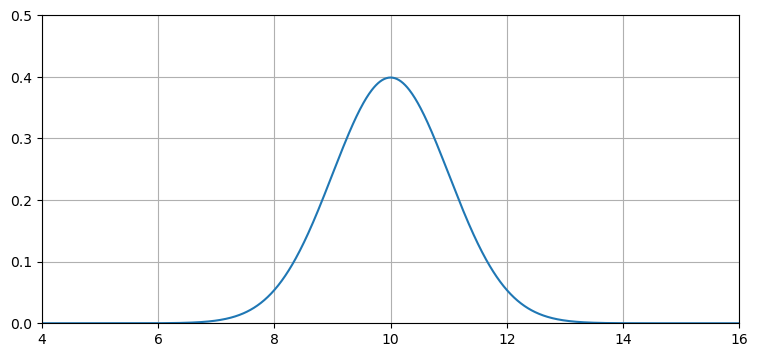

In [3]:
import filterpy.stats as stats
stats.plot_gaussian_pdf(mean=10., variance=1., 
                        xlim=(4, 16), ylim=(0, .5));

这个图形描述了我们对狗的位置的不确定。它代表了一种相当不准确的信念。虽然我们认为这只狗最有可能在10米的位置，但9米到11米左右的位置也很有可能。假设狗站着不动，我们再次询问传感器。这次是10.2万。我们可以使用这些额外的信息来改进我们的估计吗? 

直觉告诉我们可以。考虑:如果我们读取传感器500次，每次它返回一个介于8和12之间的值，并且都集中在10附近，我们应该非常确信狗接近10。当然，也可能有不同的解释。也许我们的狗是在以一种完全模拟正态分布的随机方式来回游荡。但这似乎不太可能——我从没见过狗这么做。让我们看看$\mathcal N(10,1)$的500次抽取:

Mean of readings is 10.038


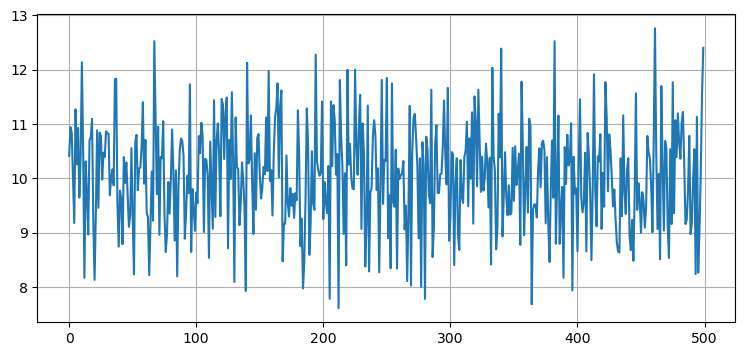

In [4]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = randn(500)*1. + 10.
plt.plot(xs, ys)
print(f'Mean of readings is {np.mean(ys):.3f}')

观察这一点证实了我们的直觉——没有狗会这样移动。然而，噪声传感器数据显然是这样的。读数的计算平均值几乎正好是10。假设狗站着不动，狗在位置10，方差是1。

## 高斯概率来更跟踪

离散贝叶斯滤波器使用概率直方图来跟踪狗。直方图中的每个竖条代表一个位置，其值为狗处于该位置的概率。
跟踪是通过一个预测和更新周期进行的。我们用了方程

$$\begin{aligned} 
\bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{Predict} \\
\mathbf x &= \mathcal L \cdot \bar{\mathbf x}\, \, &\text{Update}
\end{aligned}$$

来计算新的概率分布。回想一下，$\bar{\mathbf x}$是*先验*，$\mathcal L$ 是给定先验$\bar{\mathbf x}$的度量的*可能性* ，$f_{\mathbf x}(\bullet)$是*进程模型*，$\ast$表示*卷积*。$\mathbf x$用粗体表示它是数字的直方图或向量。

这种方法有效，但会导致直方图暗示狗可能同时出现在多个地方。而且，对于大问题的计算非常慢。

我们可以用高斯函数$\mathcal N(x， \sigma^2)$替换直方图$\mathbf x$吗?当然可以!我们已经学习了如何用高斯函数来表示信念。高斯函数，它是一个数字对$\mathcal N(\mu， \sigma^2)，$可以替代整个概率直方图:

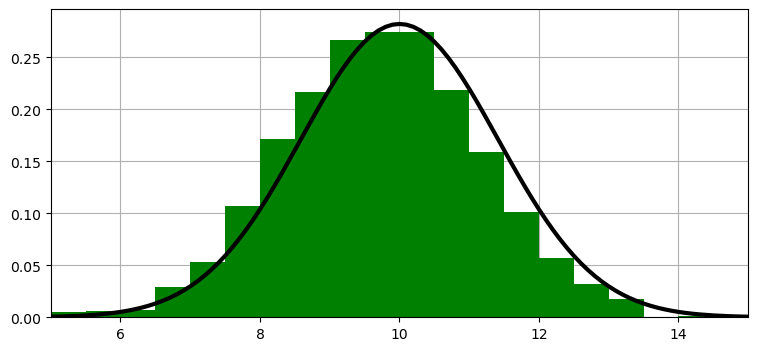

In [5]:
import kf_book.kf_internal as kf_internal
kf_internal.gaussian_vs_histogram()

我希望你能看到它的力量。我们可以用一对数字来代替几百到几千个数字:
$x = \mathcal N(\mu, \sigma^2)$. 

高斯函数的尾部向两边延伸到无穷远，所以它在直方图中包含任意多的条。如果这代表了我们对狗在走廊中的位置的信念，那么这个高斯分布覆盖了整个走廊(和整个宇宙在那个轴上)。我们认为这只狗很可能在10，但它也可能在8、14，或者以极小的概率，在10$^{80}$。

在本章中，我们将直方图替换为高斯图:

$$\begin{array}{l|l|c}
\text{discrete Bayes} & \text{Gaussian} & \text{Step}\\
\hline
\bar {\mathbf x} = \mathbf x \ast f(\mathbf x) & 
\bar {x}_\mathcal{N} =  x_\mathcal{N} \, \oplus \, f_{x_\mathcal{N}}(\bullet) &
\text{Predict} \\
\mathbf x = \|\mathcal L \bar{\mathbf x}\| & x_\mathcal{N} = L \, \otimes \, \bar{x}_\mathcal{N} & \text{Update} 
\end{array}$$
 
其中$\oplus$和$\otimes$表示高斯上的某个未知算子。我不会在书的其余部分做这个，但是下标表明$x_\mathcal{N}$是一个高斯函数。

离散贝叶斯滤波器使用卷积进行预测。我们证明了它使用了*总概率定理*，以求和的形式计算，所以也许我们可以把高斯函数加起来。它用乘法把测量和先验结合起来，所以也许我们可以把高斯分布相乘。事情能这么简单吗:

$$\begin{aligned} 
\bar x &\stackrel{?}{=} x + f_x(\bullet) \\
x &\stackrel{?}{=} \mathcal L \cdot \bar x
\end{aligned}$$

这只在两个高斯函数的和和乘积是另一个高斯函数的情况下才成立。否则，在第一个时刻后$x$将不是高斯，这个方案失败。

## 用高斯函数预测 

我们利用牛顿运动方程，根据当前速度和先前位置计算当前位置:

$$ \begin{aligned}\bar{x}_k &= x_{k-1} + v_k \Delta t \\
 &= x_{k-1} + f_x\end{aligned}$$

为了保持方程的整洁，我把$f_x(\bullet)$换成了$f_x$。

如果狗的速度是10米，它的速度是15米/秒，时间间隔是2秒长，我们有

$$ \begin{aligned} f_x &= v\Delta t = 15\cdot 2\\
\bar{x}_k &= 10 + (15\cdot 2) = 40 \end{aligned}$$

我们不确定他现在的位置和速度，所以这不行。我们需要用高斯函数来表示不确定性。
 
位置是很容易的。我们定义$x$为高斯函数。如果我们认为狗在10米，而不确定性的标准差是0.2米，我们得到$x=\mathcal N(10,0.2 ^2)$。

那我们对移动的不确定度是多少呢?我们定义$f_x$为高斯函数。如果狗的速度是15米/秒，间隔是1秒，我们的不确定性的标准差是0.7米/秒，我们得到$f_x = \mathcal N(15,0.7 ^2)$。

先验的方程是 

$$\bar x = x + f_x$$

两个高斯函数的和是多少?在上一章我证明了:

$$\begin{gathered}
\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$
 
这真是个好消息;两个高斯函数的和是另一个高斯函数!
 
数学计算是可行的，但直觉上能理解吗?想想这个抽象方程的物理表示。我们有

$$\begin{gathered}
x=\mathcal N(10, 0.2^2)\\
f_x = \mathcal N (15, 0.7^2)
\end{gathered}$$

如果相加得到：

$$\begin{aligned}\bar x &= \mu_x + \mu_{f_x} = 10 + 15 &&= 25 \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{f_x}^2 = 0.2^2 + 0.7^2 &&= 0.53\end{aligned}$$

预测的位置是之前的位置加上移动是有道理的。方差呢?这很难形成一种直觉。然而，回想一下离散贝叶斯过滤器的‘predict()’函数，我们总是会丢失信息。我们不知道狗的移动方向，所以自信会变小(方差会变大)。$\sigma_{f_x}^2$是由于对运动的不完美预测而添加到系统中的不确定性，因此我们将其添加到现有的不确定性中。
 .
让我们利用Python`collection `模块中的` namedtuple `类来实现一个高斯对象。我们可以使用元组来实现高斯函数，其中$\mathcal N(10, 0.04)$在Python中被实现为` g =(10。, 0.04)`。我们用`g[0]`来求均值，用`g[1]`来求方差。
 
` namedtuple `的工作原理与元组相同，除了你提供了类型名和字段名。理解它并不重要，但我修改了' __repr__ '方法，以使用本章中的符号显示它的值。

In [6]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

Now we can create a print a Gaussian with:

In [7]:
g1 = gaussian(3.4, 10.1)
g2 = gaussian(mean=4.5, var=0.2**2)
print(g1)
print(g2)

𝒩(μ=3.400, 𝜎²=10.100)
𝒩(μ=4.500, 𝜎²=0.040)


可以使用下标或字段名访问平均值和方差:

In [8]:
g1.mean, g1[0], g1[1], g1.var

(3.4, 3.4, 10.1, 10.1)

下面是我们的predict函数的实现，其中`pos`和` movement`是高斯元组，形式为($\mu$， $\sigma^2$):

In [9]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

让我们来测试一下。如果初始位置是高斯$\mathcal N(10,0.2 ^2)$，而移动是高斯$\mathcal N(15,0.7 ^2)$，先验是什么?

In [6]:
pos = gaussian(10., .2**2)
move = gaussian(15., .7**2)
predict(pos, move)

NameError: name 'gaussian' is not defined

 之前的数据表明，这只狗的估值为25 m，方差为0.53 m$^2$，这是我们手工计算的结果。

## 用高斯函数更新 

离散贝叶斯滤波器将我们对狗的位置的信念编码成概率直方图。分布是离散的和多峰的。它可以表达强烈的信念，即狗在同一时间处于两种位置，并且这些位置是离散的。
 
我们建议用高斯分布代替直方图。离散贝叶斯滤波器使用此代码来计算后验:


```python
def update(likelihood, prior):
    posterior = likelihood * prior
    return normalize(posterior)
```
它是方程的一个实现:

$$x = \| \mathcal L\bar x \|$$
 
我们已经证明了我们可以用高斯函数来表示先验。可能性呢?可能性是给定当前状态的测量的概率。我们已经学习了如何用高斯函数表示测量值。例如，也许我们的传感器显示狗在23米的高度，标准差是0.4米。我们的测量，表示为一种可能性，是$z = \mathcal N(23, 0.16)$。
 
似然和先验均采用高斯模型。我们能乘高斯函数吗?两个高斯函数的乘积是另一个高斯函数吗?

是的，前者是，而且几乎是后者!在上一章中，我证明了两个高斯的乘积与另一个高斯的乘积成正比。 

$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$
 
我们可以立即推断出几件事。如果我们将结果归一化，乘积是另一个高斯分布。如果一个高斯分布是概率，第二个高斯分布是先验，那么均值就是先验和测量值的比例和。方差是先验方差和测量方差的组合。最后，方差完全不受平均值的影响!

我们用贝叶斯的术语来表述如下:

$$\begin{aligned}
\mathcal N(\mu, \sigma^2) &= \| prior \cdot likelihood \|\\
&= \| \mathcal{N}(\bar\mu, \bar\sigma^2)\cdot \mathcal{N}(\mu_z, \sigma_z^2) \|\\
&= \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{aligned}$$

如果我们在函数`gaussian_multiply()`中实现它，我们可以实现过滤器的更新步骤为

In [7]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

# test the update function
predicted_pos = gaussian(10., .2**2)
measured_pos = gaussian(11., .1**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

NameError: name 'gaussian' is not defined

如果我们使用更具体的名称，可能会更清楚:

```python
def update_dog(dog_pos, measurement):
    estimated_pos = gaussian_multiply(measurement, dog_pos)
    return estimated_pos  
```
这样做不那么抽象，可能有助于理解，但这是糟糕的编码实践。我们正在编写一个适用于任何问题的卡尔曼过滤器，而不仅仅是在走廊上跟踪狗，所以我们不会使用带有“dog”的变量名。同样，这种形式掩盖了概率乘以先验的事实。
 
我们已经实现了大部分的过滤器，但是我担心这一步还是有点让人困惑。我已经断言我们可以乘高斯函数并且它正确地执行更新步骤，但为什么是这样呢?让我们绕道花点时间乘以高斯函数。

### 理解高斯乘法
 
让我们绘制$\mathcal{N}(10,\, 1) \times \mathcal{N}(10,\, 1)$的pdf。你能在不看结果的情况下确定它的形状吗?新的意义应该是什么?曲线是更宽，更窄，还是与$\mathcal{N}(10，\, 1)$相同?

𝒩(μ=10.000, 𝜎²=0.500)


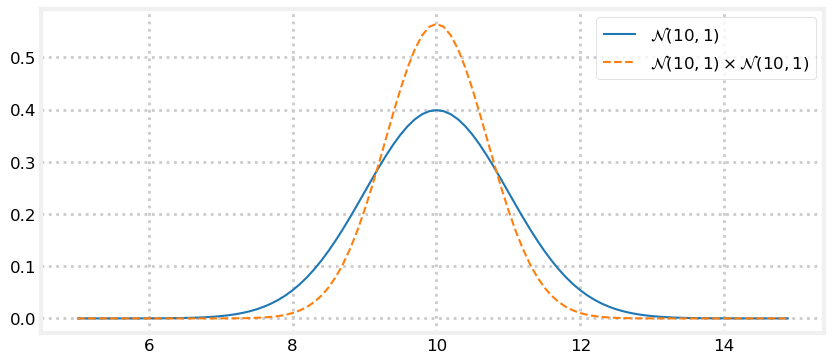

In [12]:
z = gaussian(10., 1.)  # Gaussian N(10, 1)

product = gaussian_multiply(z, z)

xs = np.arange(5, 15, 0.1)
ys = [stats.gaussian(x, z.mean, z.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')

ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$', ls='--')
plt.legend()
print(product)

乘法的结果比原来的高斯函数高且窄，但平均值不变。这符合你的直觉吗?

把高斯函数看成两个测量值。如果我测量两次，每次都是10米，我应该得出结论，长度接近10米。因此，平均值应该是10。得出这个长度实际上是11或9.5是没有意义的。另外，我对两次测量比一次更有信心，所以结果的方差应该更小。

“三思而后行”是一句名言。高斯乘法是这个物理事实的数学模型。 
 
我不太可能连续两次得到相同的测量值。现在让我们绘制$\mathcal{N}(10.2,\, 1) \times \mathcal{N}(9.7,\, 1)$的pdf。你认为结果会怎样?想想看，然后看这个图。

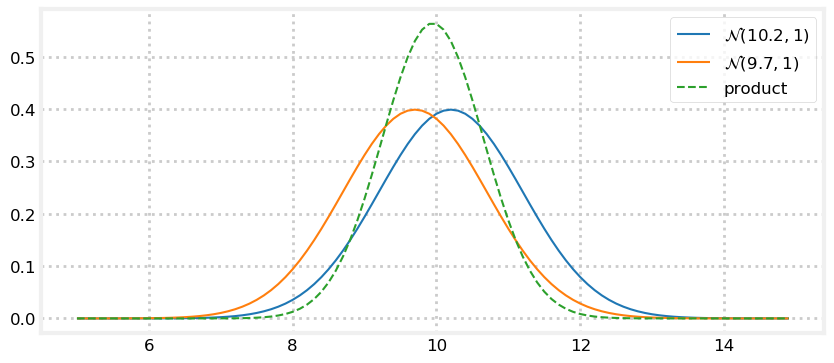

In [13]:
def plot_products(g1, g2): 
    plt.figure()
    product = gaussian_multiply(g1, g2)

    xs = np.arange(5, 15, 0.1)
    ys = [stats.gaussian(x, g1.mean, g1.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g1.mean, g1.var))

    ys = [stats.gaussian(x, g2.mean, g2.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g2.mean, g2.var))

    ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
    plt.plot(xs, ys, label='product', ls='--')
    plt.legend();
    
z1 = gaussian(10.2, 1)
z2 = gaussian(9.7, 1)
 
plot_products(z1, z2)

如果你让两个人测量一张桌子到墙的距离，一个得到10.2米，另一个得到9.7米，你最好的猜测一定是平均值，如果你同样相信两个人的技巧，那就是9.95米。
 
回想一下g-h过滤器。我们一致认为，如果我用两个秤称体重，第一个读数为160磅，第二个读数为170磅，而且两个都同样准确，最好的估计是165磅。此外，我应该对165磅比160磅或170磅更有信心，因为我现在有两个读数，都接近这个估计，增加了我的信心，没有一个是大错特错的。
 
在更复杂的情况下，这就违反了直觉，所以让我们进一步考虑它。也许一个更合理的假设是一个人犯了错误，真实的距离是10.2或9.7，但肯定不是9.95。这当然是可能的。但我们知道我们的测量结果是有噪声的，所以我们没有理由认为其中一个测量结果是没有噪声的，或者认为一个人的测量结果有很大的误差，让我们可以放弃他们的测量结果。根据现有资料，最好的估计是9.95。
  
在卡尔曼滤波的更新步骤中，我们并不是将两个测量值结合在一起，而是将一个测量值和之前的估计值结合在一起。我们讨论了g-h滤波器的逻辑。不管我们是将来自两个测量的信息，还是一个测量和一个预测的信息结合在一起，数学都是一样的。
 
我们来看看。我将创建一个相当不准确的先验$\mathcal N(8.5, 1.5)$和一个更精确的度量$\mathcal N(10.2, 0.5)。$“准确”我指的是传感器的方差比先验的方差更小，不是我不知怎么知道狗更接近10.2而不是8.5。接下来，我将绘制相反的关系:$\mathcal N(8.5, 0.5)$的精确先验和$\mathcal N(10.2, 1.5)$的不精确度量。

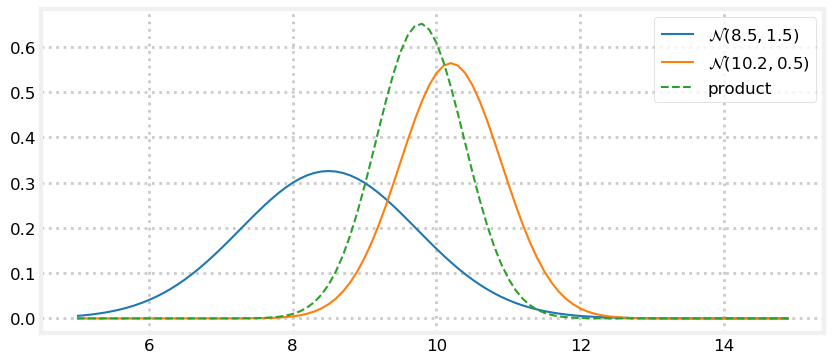

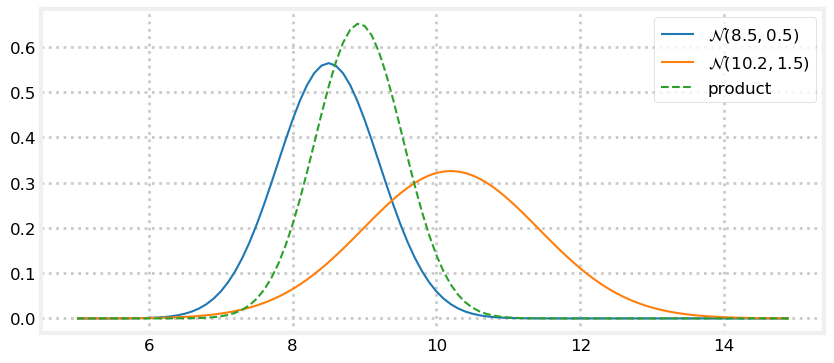

In [14]:
prior, z = gaussian(8.5, 1.5), gaussian(10.2, 0.5)
plot_products(prior, z)

prior, z = gaussian(8.5, 0.5), gaussian(10.2, 1.5)
plot_products(prior, z)

 结果是一个高斯比任何一个输入都高。这是有道理的，我们已经加入了信息，所以方差应该已经减少了。注意结果如何更接近方差更小的输入。我们对这个值更有信心，所以更重视它是有意义的。
 
这似乎行得通，但真的正确吗?关于这一点还有更多要说的，但我想让一个工作过滤器运行，这样你就可以具体地体验它。之后，我们将重新讨论高斯乘法，并确定它为什么是正确的。

### 互动的例子

这个交互式代码提供了滑动条来改变两个相乘的高斯函数的均值和方差。当您移动滑块时，情节将被重绘。将光标放在代码单元格内并按CTRL+Enter执行它。

In [8]:
from ipywidgets import interact

def interactive_gaussian(m1, m2, v1, v2):
    g1 = gaussian(m1, v1)
    g2 = gaussian(m2, v2)
    plot_products(g1, g2)
    
interact(interactive_gaussian,
         m1=(5, 10., .5), m2=(10, 15, .5), 
         v1=(.1, 2, .1), v2=(.1, 2, .1));

interactive(children=(FloatSlider(value=7.5, description='m1', max=10.0, min=5.0, step=0.5), FloatSlider(value…

## 一阶卡尔曼滤波
 
让我们回到具体的术语，实现一个卡尔曼滤波器。我们实现了`update()`和`predict()`函数。我们只需要编写一些样板代码来模拟狗并创建度量。我在`kf_internal` 中放置了一个`DogSimulation` 类，以避免在任务中分心。
 
这个样板代码通过定义平均值、方差和生成模拟狗的运动来设置问题。

In [16]:
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import DogSimulation

np.random.seed(13)

process_var = 1. # variance in the dog's movement
sensor_var = 2. # variance in the sensor

x = gaussian(0., 20.**2)  # dog's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x
  
# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)]

这是卡尔曼滤波器。

In [17]:
print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    kf_internal.print_gh(prior, x, z)

print()
print('final estimate:        {:10.3f}'.format(x.mean))
print('actual final position: {:10.3f}'.format(dog.x))

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  401.000	1.354	  1.352   1.990
  2.352    2.990	1.882	  2.070   1.198
  3.070    2.198	4.341	  3.736   1.047
  4.736    2.047	7.156	  5.960   1.012
  6.960    2.012	6.939	  6.949   1.003
  7.949    2.003	6.844	  7.396   1.001
  8.396    2.001	9.847	  9.122   1.000
 10.122    2.000	12.553	 11.338   1.000
 12.338    2.000	16.273	 14.305   1.000
 15.305    2.000	14.800	 15.053   1.000

final estimate:            15.053
actual final position:     14.838


  这是一个过滤器的动画。预测用红色三角形表示。预测完成后，滤波器接收到下一个测量值，用黑色圆圈表示。然后过滤器在两者之间形成一个估计。

In [9]:
from kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider

# save output in these lists for plotting
xs, predictions = [], []

process_model = gaussian(velocity, process_var) 

# perform Kalman filter
x = gaussian(0., 20.**2)
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i])

    plt.xlim(-1, 10)
    plt.ylim(0, 20)
    plt.legend(loc=2);
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

NameError: name 'gaussian' is not defined

我绘制了先验(标记为*预测*)、测量值和滤波器输出。对于循环的每一次迭代，我们形成一个先验，进行测量，从测量中形成一个可能性，然后将可能性合并到先验中。

如果你看这个图，你会发现过滤估计总是在测量和预测之间。回想一下，对于g-h滤波器，我们认为估计必须总是在测量值和先验值之间。在两个值之外选择一个值是没有意义的。如果我预测我在10岁，但测量到我在9岁，那就决定我一定在8岁或11岁是愚蠢的。

## 代码走读

现在让我们浏览一下代码。

```python
process_var = 1.
sensor_var = 2.
```
 
这些是过程模型和传感器的差异。传感器方差的含义应该很清楚-它是在每个测量中有多少方差。流程方差是流程模型中有多少错误。我们预测狗每向前走1米。狗很少做我们期望的事情，像小山或松鼠的气味会改变它的进程。如果这是一个对数字指令做出反应的机器人，其性能会好得多，也许方差会是$\sigma^2= 0.05 $。这些并不是“神奇的”数字;方差的平方根是距离误差，单位为米。简单地代入数字就可以使卡尔曼滤波器工作，但如果数字不能反映真实情况，滤波器的性能就会很差。

```python
x = gaussian(0., 20.**2)
```
这是用高斯函数表示的狗的初始位置。位置是0米，方差是400米$^2$，这是20米的标准差。你可以这样想"我相信99.7%的精度，位置是0±60米"这是因为在高斯情况下，99.7%的数值落在均值的$\pm3\sigma$之内。

```python
process_model = gaussian(velocity, process_var)
```
这就是过程模型——描述我们认为狗是如何移动的。我怎么知道速度?魔法吗?把它当作一个预测，或者我们有一个二次速度传感器。如果这是一个机器人，那么这就是机器人的控制输入。在接下来的章节中，我们将学习如何处理没有速度传感器或输入的情况，所以现在请接受这个简化。

接下来我们初始化模拟并创建10个测量值:

```python
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

zs = [dog.move_and_sense() for _ in range(10)]
```
 现在我们输入 `predict() ... update()`的循环。

```python
for z in zs:
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
```
 
第一次通过' prior '循环是'(1.0,401.0)'，可以在打印的表中看到。在预测之后，我们认为我们是1.0，方差现在是401，从400上升。方差变差了，这是在预测步骤中经常发生的，因为它涉及到信息的丢失。
 
然后我们使用' prior '作为当前位置调用update函数。
 
我得到的结果是:`pos = (1.352, 1.990), z = 1.354`。
 
发生了什么?狗的实际位置是1.0，但由于传感器噪声，测量的位置是1.354。这与预测值1相差甚远。先验方差为401 m$^2$ 。大的方差意味着置信度非常低，因此过滤器估计的位置非常接近测量值:1.352。
 
现在看看方差:1.99 m$^2$。它从401 m$^2$大幅下降。为什么?嗯，射频识别有一个相当小的方差2.0 m$^2$，所以我们比之前更信任它。然而，之前的信念确实包含了一些有用的信息，所以我们的方差现在略小于2.0。
 
现在软件开始循环，依次调用`predict()`和`update()`。到最后，最终估计的位置是15.053 vs实际位置14.838。方差收敛到1.0 m$^2$。

现在看这个图。噪声测量用黑色圆圈表示，滤光结果用蓝色实线表示。两者的噪声都很大，但请注意测量值的噪声有多大。我用红色三角形标出了预测结果。估计总是在先验和测量之间。这是你的第一个卡尔曼滤波器，它似乎工作!

过滤只用几行代码就实现了。大部分代码要么是初始化、存储数据、模拟狗的运动，要么是打印结果。执行过滤的代码非常简洁:

```python
prior = predict(x, process_model)
likelihood = gaussian(z, sensor_var)
x = update(prior, likelihood)
```
如果我们不使用`predict`和`update`函数，代码可能是:

```python
for z in zs:
    # predict
    dx = velocity*dt
    pos = pos + dx
    var = var + process_var

    # update
    pos  = (var*z + sensor_var*pos) / (var + sensor_var)
    var = (var * sensor_var) / (var + sensor_var)
```    

只用5行非常简单的数学运算就可以实现整个过滤器!

在这个例子中，我只绘制了10个数据点，这样打印语句的输出就不会让我们不知所措。现在让我们看看使用更多数据的过滤器的性能。方差在虚线之间用浅黄色标出。我已经增加了过程的大小和传感器的方差，所以它们更容易在图表上看到-当然，对于一个真正的卡尔曼滤波器，你不会随机改变这些值。

	4.4502 2.6507 2.2871 2.1955 2.1712
	2.1647 2.1629 2.1625 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623


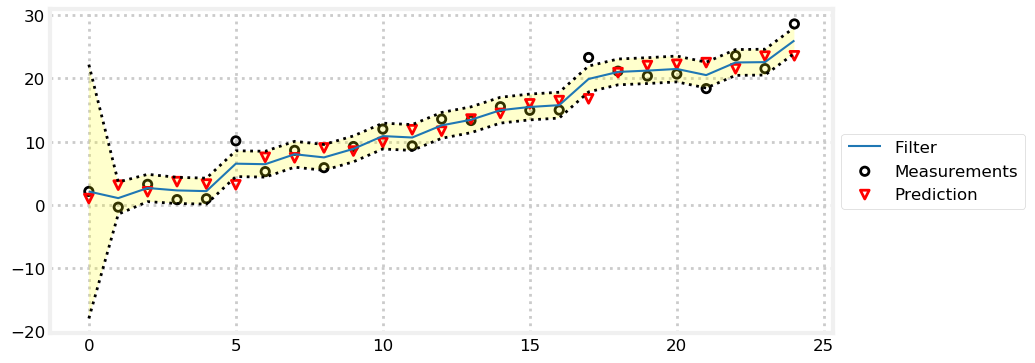

In [19]:
process_var = 2.
sensor_var = 4.5
x = gaussian(0., 400.)
process_model = gaussian(1., process_var)
N = 25

dog = DogSimulation(x.mean, process_model.mean, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

xs, priors = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(zs):
    prior = predict(x, process_model)    
    x = update(prior, gaussian(z, sensor_var))
    priors[i] = prior
    
    xs[i] = x

book_plots.plot_measurements(zs)
book_plots.plot_filter(xs[:, 0], var=priors[:, 1])
book_plots.plot_predictions(priors[:, 0])
book_plots.show_legend()
kf_internal.print_variance(xs)

这里我们可以看到方差经过9个步骤收敛到2.1623。这意味着我们对我们的位置估计变得非常有信心。它等于$\sigma=1.47$米。相比之下，传感器的$\sigma=2.12$米。最初的几个测量是不确定的，由于我们的初始位置的不确定性，但滤波器迅速收敛到一个比传感器的方差更低的估计!
 
这段代码完全实现了一个卡尔曼滤波器。如果你曾经试着读过这些文献，你可能会感到惊讶，因为这看起来一点也不像那些书中没完没了的数学。只要我们担心“使用”这些方程而不是“推导”它们，这个话题就可以接近了。此外，我希望你会同意，你对正在发生的事情有很好的直觉把握。我们用高斯函数来表示信念，随着时间的推移，它们会变得更好，因为更多的测量意味着我们有更多的数据来处理。

### 练习:修改方差值
 
修改`process_var`和`sensor_var`的值，并注意对过滤器和方差的影响。哪个对方差收敛有更大的影响?例如，这会导致较小的方差:

```python
process_var = 40
sensor_var = 2
```
    
或:

```python
process_var = 2
sensor_var = 40
```

### KF动画

如果你在浏览器中阅读这篇文章，你将能够看到这个句子下面直接跟踪狗的过滤器的动画。
<img src='animations/05_dog_track.gif'>

上面的图用绿色显示了过滤器的输出，用红色虚线显示了测量值。下面的图显示了每一步的高斯分布。 
 
当轨迹第一次开始时，你可以看到测量值与最初的预测有很大的不同。此时高斯概率很小(曲线又低又宽)，所以滤波器不相信它的预测。因此，滤波器对其估计值进行了大量的调整。随着滤波器的创新，你可以看到随着高斯变高，表明在估计中更大的确定性，滤波器的输出变得非常接近一条直线。在' x = 15 '或更大的时候，你可以看到测量中有大量的噪声，但与第一次噪声测量的变化相比，滤波器对它的反应不大。

## Kalman增益

我们看到过滤器起作用了。现在让我们回到数学上来理解发生了什么。后验$x$被计算为概率乘以先验($\mathcal L \bar x$)，其中两者都是高斯函数。

因此后验的平均值为:

$$
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2}
$$

我使用下标$z$表示测量值。我们可以把它重写为:

$$\mu = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\bar\mu$$

在这种形式中，很容易看到我们是按权重来缩放测量值和先验值: 

$$\mu = W_1 \mu_z + W_2 \bar\mu$$

权重和为1，因为分母是标准化项。我们引入一个新的术语，$K=W_1$，得到:

$$\begin{aligned}
\mu &= K \mu_z + (1-K) \bar\mu\\
&= \bar\mu + K(\mu_z - \bar\mu)
\end{aligned}$$

其中

$$K = \frac {\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}$$
 
$K$是*卡尔曼增益*。这是卡尔曼滤波的关键。它是一个缩放项，选择一个介于$\mu_z$和$\bar\mu$之间的值。
 
让我们来看几个例子。如果测量的准确度是之前的9倍，那么$\bar\sigma^2 = 9\sigma_z^2$，并且

$$\begin{aligned}
\mu&=\frac{9 \sigma_z^2 \mu_z + \sigma_z^2\, \bar\mu} {9 \sigma_z^2 + \sigma_\mathtt{z}^2} \\
&= \left(\frac{9}{10}\right) \mu_z + \left(\frac{1}{10}\right) \bar\mu
\end{aligned}
$$
 
因此$K = \frac 9{10}$，为了形成后验，我们取测量值的十分之九和先验值的十分之一。

If the measurement and prior are equally accurate, then $\bar\sigma^2 = \sigma_z^2$ and
如果测量值和先验值一样准确，那么$\bar\sigma^2 = \sigma_z^2$  和

$$\begin{gathered}
\mu=\frac{\sigma_z^2\,  (\bar\mu + \mu_z)}{2\sigma_\mathtt{z}^2} \\
= \left(\frac{1}{2}\right)\bar\mu + \left(\frac{1}{2}\right)\mu_z
\end{gathered}$$

也就是两个均值的平均值。取两个相等精确值的平均值是很直观的。

我们也可以用卡尔曼增益表示方差:

$$\begin{aligned}
\sigma^2 &= \frac{\bar\sigma^2 \sigma_z^2 } {\bar\sigma^2 + \sigma_z^2} \\
&= K\sigma_z^2 \\
&= (1-K)\bar\sigma^2 
\end{aligned}$$

我们可以通过这个图表来理解这一点:

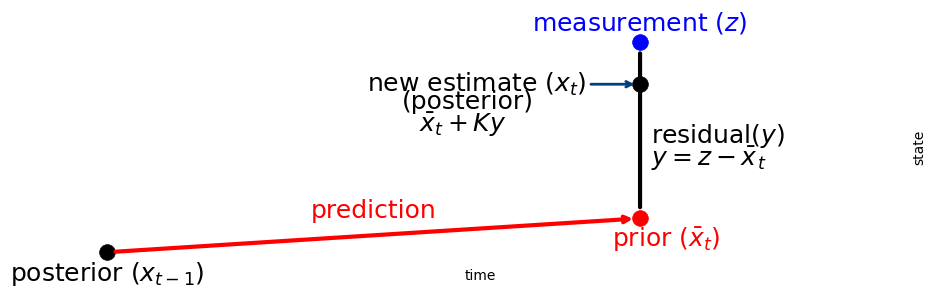

In [10]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

卡尔曼增益$K$是沿着残差选择一个值的比例因子。这导致了`update()` 和 `predict()`的替代但等效的实现:

In [11]:
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

为什么我要把它写成这种形式，为什么我要选择这些糟糕的变量名?一些相关的原因。大多数书籍和论文都是以这种形式介绍卡尔曼滤波器。我从贝叶斯原理推导出的过滤器不是未知的，但它几乎没有被经常使用。可选的推导自然会引出这种形式的方程。此外，多元卡尔曼滤波器的方程与这些方程几乎完全相同。所以，你需要学习和理解它们。
 
`z`, `P`, `Q`, 和 `R`这四个名字是从哪里来的?你会在本书的其余部分看到它们的使用。在文献中，$R$几乎普遍用于测量噪声，$Q$用于过程噪声，$P$用于状态方差。使用$z$进行测量是很常见的，尽管不是通用的。几乎你读过的每一本书和报纸都会用到这些变量名。要习惯它们。
  
这也是一种考虑过滤的强大方法。这是我们推导g-h滤波器的方法。它强调取剩余的$y = \mu_z - \bar\mu$，找到卡尔曼增益作为先验的不确定性和测量的比例$K = P/(P+R)$，并通过将$Ky$加到先验来计算后验。
 
这种形式掩盖了贝叶斯方面，正如我们将可能性乘以先验的事实一样。两种观点是等价的，因为数学是相同的。我之所以选择贝叶斯方法，是因为我认为它能更直观而深刻地理解概率推理。这种使用$K$的替代形式可以深入理解所谓的“正交投影”方法。卡尔曼博士在发明这个过滤器时，使用的是这种推导，而不是贝叶斯推理。你将在接下来的几章中了解更多。

## 算法的完整描述

回想一下我们用于g-h过滤器的图表:
<img src="./figs/residual_chart.png">

 我们在这一章也做了同样的事情。卡尔曼滤波器进行预测，进行测量，然后在两者之间形成一个新的估计。
 d.
**理解这一点非常重要**:本书中的每个过滤器都实现了相同的算法，只是使用了不同的数学细节。在后面的章节中，数学可能会变得很有挑战性，但概念很容易理解。
 
重要的是要了解特定过滤器的方程式的细节，并理解方程式在计算什么以及为什么。有大量的过滤器。它们都使用不同的数学来实现相同的算法。数学的选择影响结果的质量和问题的表现，但不影响潜在的想法。

这里是泛型算法:

**初始化**

    1. 初始化滤波器的状态
    2. 在状态中初始化我们的信念
    
**预测**

    1. 使用系统行为来预测下一个时间步骤的状态
    2. 调整信念以解释预测中的不确定性
    
**更新**

    1. 获得一个测量和它的准确性相关的信念 
    2. 计算估计状态和测量之间的残差
    3. 根据测量结果计算比例因子或者预测更准确
    4. 在预测和测量之间设置状态对比例因子
    5. 根据测量确认度更换新状态信念  
  
您将很难找到一个不适合这种形式的贝叶斯过滤算法。有些过滤器不包括某些方面，如预测中的错误，而另一些则有非常复杂的计算方法，但它们都是这样做的。

一元卡尔曼滤波方程为:

<u>预测</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation} & \text{Kalman Form}\\
\hline
 \bar x = x + f_x & \bar\mu = \mu + \mu_{f_x} & \bar x = x + dx\\
& \bar\sigma^2 = \sigma^2 + \sigma_{f_x}^2 & \bar P = P + Q\\
\hline
\end{array}$


<u>更新</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation}& \text{Kalman Form}\\
\hline
 x = \| \mathcal L\bar x\| & y = z - \bar\mu & y = z - \bar x\\
 & K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2} & K = \frac {\bar P}{\bar P+R}\\
 & \mu = \bar \mu + Ky & x = \bar x + Ky\\
 & \sigma^2 = \frac {\bar\sigma^2 \sigma_z^2} {\bar\sigma^2 + \sigma_z^2} & P = (1-K)\bar P\\
\hline
\end{array}$

## 与g-h和离散贝叶斯滤波器比较

现在是时候了解这三种过滤器在如何建模误差方面的区别了。对于g-h过滤器，我们的测量模型如下图所示:

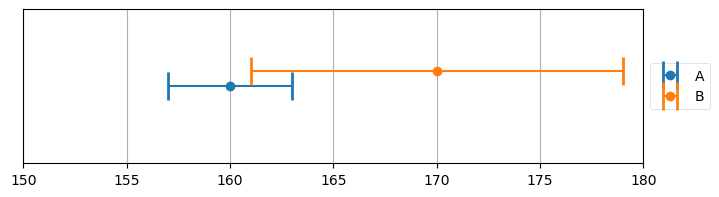

In [12]:
book_plots.plot_errorbars([(160, 3, 'A'), (170, 9, 'B')], xlims=(150, 180))

 传感器A返回160的测量值，传感器B返回170。这些条是[*误差条*](https://en.wikipedia.org/wiki/Error_bar) -它们说明了测量的可能误差范围。因此，A测量的实际值可以在157到163之间，而B测量的值可以在161到179之间。
 
我当时没有定义它，但这是一个[*均匀分布*](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous))。均匀分布赋予该范围内的任何事件相同的概率。根据这个模型，传感器A同样有可能读取157,160或163。任何超出这个范围的值都有0的概率。

我当时没有定义它，但这是一个[*均匀分布*](https://en.wikipedia.org/wiki/Uniform_distribution_(continuous))。均匀分布赋予该范围内的任何事件相同的概率。根据这个模型，传感器A同样有可能读取157,160或163。任何超出这个范围的值都有0的概率。
 
我们可以用高斯函数来模拟这种情况。我将对传感器A使用$\mathcal{N}(160, 3^2)$，对传感器b使用$\mathcal{N}(170, 9^2)$。

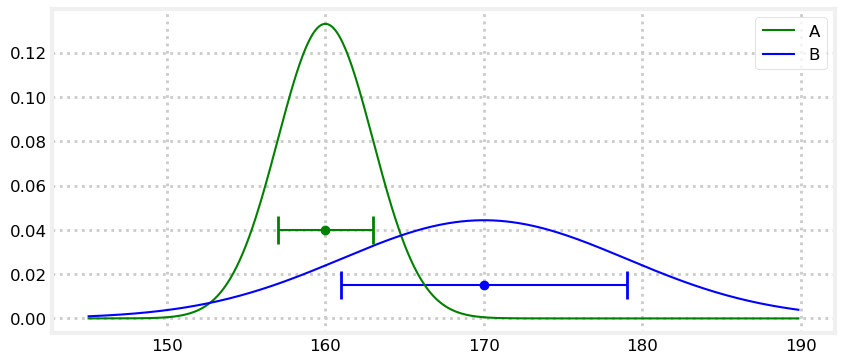

In [23]:
xs = np.arange(145, 190, 0.1)
ys = [stats.gaussian(x, 160, 3**2) for x in xs]
plt.plot(xs, ys, label='A', color='g')

ys = [stats.gaussian(x, 170, 9**2) for x in xs]
plt.plot(xs, ys, label='B', color='b')
plt.legend();
plt.errorbar(160, [0.04], xerr=[3], fmt='o', color='g', capthick=2, capsize=10)    
plt.errorbar(170, [0.015], xerr=[9], fmt='o', color='b', capthick=2, capsize=10);

使用均匀分布或高斯分布是一种建模选择。两者都不能完全描述现实。在大多数情况下，高斯分布更为实际。大多数传感器更有可能返回接近被测量值的读数，而不太可能返回远离该值的读数。高斯模型模拟了这种趋势。相反，均匀分布假设在一个范围内的任何测量都是等可能的。
 
现在让我们看看离散贝叶斯滤波器中使用的离散分布。该模型将可能值的范围划分为离散范围，并为每个bucket分配一个概率。这种分配可以是完全任意的，只要概率和为1。

让我们用均匀分布、高斯分布和离散分布来绘制一个传感器的数据。

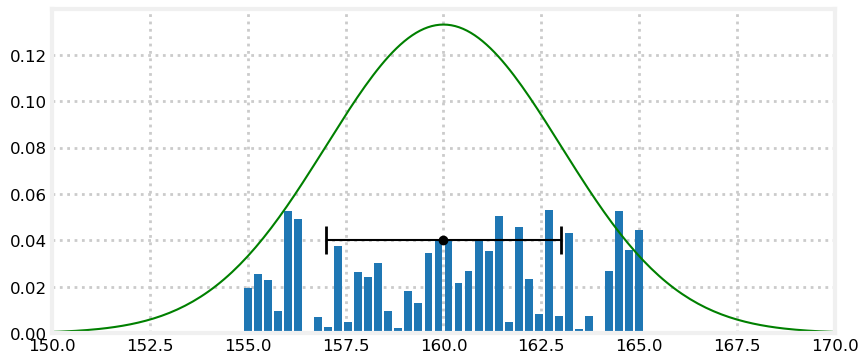

In [24]:
from random import random
xs = np.arange(145, 190, 0.1)
ys = [stats.gaussian(x, 160, 3**2) for x in xs]
belief = np.array([random() for _ in range(40)])
belief = belief / sum(belief)

x = np.linspace(155, 165, len(belief))
plt.gca().bar(x, belief, width=0.2)
plt.plot(xs, ys, label='A', color='g')
plt.errorbar(160, [0.04], xerr=[3], fmt='o', color='k', capthick=2, capsize=10)    
plt.xlim(150, 170);

我用随机数来组成离散分布来说明它可以模拟任意概率分布。有了足够的离散区域，我们就可以对任何传感器的误差特性进行建模，不管它有多复杂。但这种能力带来了数学上的难题。乘或加高斯函数需要两行数学运算，结果是另一个高斯函数。这种规律性允许我们对过滤器的性能和行为进行强大的分析。相乘或添加一个离散分布需要对数据进行循环，我们没有简单的方法来描述结果。分析基于离散分布的滤波器的性能特性是极其困难甚至不可能的。
  
这里没有“正确”选项。在本书的后面，我们将介绍使用离散分布的*粒子滤波器*。它是一种非常强大的技术，因为它可以处理任意复杂的情况。这是以降低性能为代价的，并且会阻碍分析分析。

现在，我们将忽略这些问题，并在接下来的几章中继续使用高斯函数。随着我们的进展，您将了解在我们的数学模型中使用高斯函数的优点和局限性。

## 设计滤波器简介

到目前为止，我们已经开发了用于位置传感器的滤波器。我们现在已经习惯了这个问题，可能会觉得对不同的问题执行卡尔曼滤波器是不合适的。说实话，这次演讲中还有很多信息缺失。下面几章将填补空白。不过，让我们通过设计和实现一个温度计的卡尔曼滤波器来感受一下。温度计的传感器输出与被测温度相对应的电压。我们已经阅读了传感器制造商的规格说明，它告诉我们，传感器显示白噪声的标准偏差为0.13伏特。
 
我们可以用这个功能来模拟温度传感器的测量:

In [25]:
def volt(voltage, std):
    return voltage + (randn() * std)

现在我们需要编写卡尔曼滤波处理循环。与前面的问题一样，我们需要执行一个预测和更新周期。传感步骤可能看起来很清楚——调用`volt()`来获得测量，将结果传递给 `update()`方法，但预测步骤呢?我们没有一个传感器来检测电压的“运动”，我们希望电压在任何小的持续时

一如既往，我们将相信数学。我们没有已知的动向，所以我们将它设为零。然而，这意味着我们预测温度永远不会改变。如果这是真的，那么随着时间的推移，我们应该对我们的结果变得非常自信。一旦过滤器有足够的测量值，它将变得非常自信，它可以预测随后的温度，这将导致它忽略由于实际温度变化而导致的测量结果。这被称为“自鸣得意”过滤器，这是你想要避免的。因此，我们将在预测步骤中加入一点误差，告诉滤波器不要低估电压随时间的变化。在下面的代码中，我设置`process_var = .05**2`。这是每个时间步长的电压变化的期望方差。我选择这个值只是为了能够显示方差在更新和预测步骤中是如何变化的。对于一个真正的传感器，您可以将这个值设置为您预期的实际变化量。例如，如果它是室内环境空气温度的温度计，这将是一个非常小的数字，如果这是化学反应室的热电偶，这将是一个很高的数字。我们将在后面的章节中详细介绍如何选择实际值。

让我们看看会发生什么。

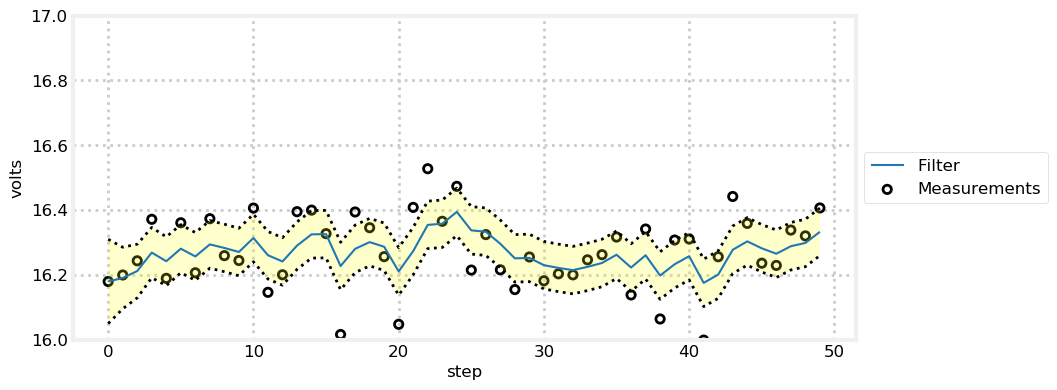

Variance converges to 0.005


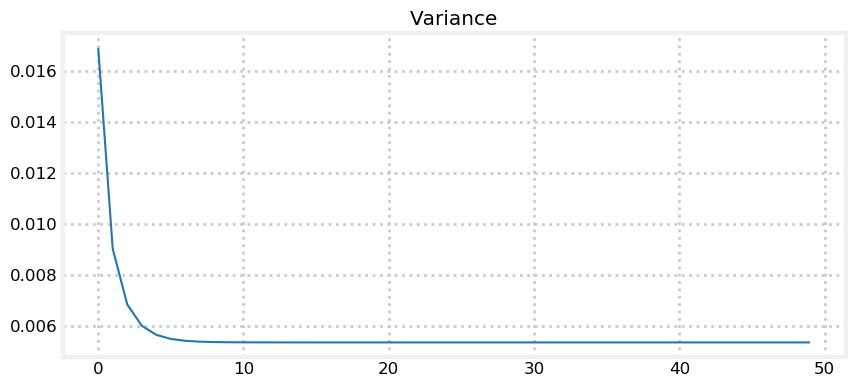

In [26]:
temp_change = 0
voltage_std = .13
process_var = .05**2
actual_voltage = 16.3

x = gaussian(25., 1000.) # initial state
process_model = gaussian(0., process_var)

N = 50
zs = [volt(actual_voltage, voltage_std) for i in range(N)]
ps = []
estimates = []

for z in zs:
    prior = predict(x, process_model)
    x = update(prior, gaussian(z, voltage_std**2))

    # save for latter plotting
    estimates.append(x.mean)
    ps.append(x.var)

# plot the filter output and the variance
book_plots.plot_measurements(zs)
book_plots.plot_filter(estimates, var=np.array(ps))
book_plots.show_legend()
plt.ylim(16, 17)
book_plots.set_labels(x='step', y='volts')
plt.show()
    
plt.plot(ps)
plt.title('Variance')
print('Variance converges to {:.3f}'.format(ps[-1]))

第一个图显示了单个传感器测量值与滤波器输出值的对比。尽管传感器中存在大量的噪声，但我们很快就发现了传感器的近似电压。在我刚刚完成的运行时，从过滤器的最后电压输出是$16.213$，这是相当接近的$16.4$使用的`volt()`函数。在其他运行中，我得到了更大或更小的结果。
 
规格表听起来就是规格。任何单独的传感器将显示不同的性能基于正常的制造变化。值通常是最大值-规范保证性能至少是那么好。如果你买了一件昂贵的设备，它通常会附带一张纸，上面显示你的特定项目的测试结果;这类人通常是非常值得信赖的。另一方面，如果这是一个便宜的传感器，它很可能收到很少或没有测试之前出售。制造商通常会测试他们输出的一小部分，以验证样品是否在期望的性能范围内。如果您有一个关键的应用程序，您将需要仔细阅读规格表，以弄清楚它们的范围是什么意思。他们保证他们的数字是最大的，还是说，$3\sigma$错误率?每个项目都测试了吗?方差是正态分布，还是其他分布?最后，制造业并不完美。你的零件可能有缺陷，与表上的性能不符。

例如，我正在看一个气流传感器的数据表。有一个字段*重复性*，值为$\pm 0.50\%$。这是高斯分布吗?是否存在偏见?例如，可能重复性在低温下接近$0.0\%$，在高温下总是接近$+0.50\%$。电气元件的数据表通常包含“典型性能特性”一节。它们用于捕获在表中不容易传递的信息。例如，我正在看一个图表显示输出电压vs电流为LM555定时器。有三条曲线显示了不同温度下的性能。理想的响应是线性的，但所有三条线都是弯曲的。这说明了电压输出的误差可能不是高斯分布的-在这个芯片的情况下，较高的温度导致较低的电压输出，如果输入电流非常高，电压输出是相当非线性的。
 
正如您可能猜到的，为传感器的性能建模是创建性能良好的卡尔曼滤波器的难点之一。

### 动画
 
对于那些在浏览器中阅读这篇文章的人，这里有一个显示过滤器工作的动画。如果你没有使用浏览器，你可以在https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/animations/05_volt_animate.gif上看到这个图。

<img src='animations/05_volt_animate.gif'>

 动画中的顶部图形为预测的下一个电压绘制一条绿色的线，然后为实际测量绘制一条红色的“+”，绘制一条淡红色的线来表示残余，然后绘制一条蓝色的线来表示滤波器的输出。你可以看到，当过滤器启动时，所做的修正是相当大的，但只更新了几次后，过滤器只调整了一小部分输出，即使测量距离它很远。
 
下面的图显示了滤波器创新时的高斯信念。当滤波器开始时，高斯曲线的中心是25，我们对电压的初始猜测，由于我们的初始不确定性，它是非常宽和短的。但随着滤波器的创新，高斯分布迅速移动到16.0左右，并变得更高，反映出滤波器对电压的估计越来越有信心。你也会注意到高斯函数的高度会有一点上下反弹。如果你仔细观察，你会发现高斯曲线在预测步骤中变得更短、更分散，而在滤波器包含另一个测量值时变得更高、更窄。
 
从g-h过滤器的角度来考虑这个动画。在每一步，g-h滤波器进行预测，进行测量，计算残差(预测和测量之间的差)，然后基于比例因子$g$在残差线上选择一个点。卡尔曼滤波器做的是完全相同的事情，除了比例因子$g$随时间而变化。当滤波器对其状态变得更有信心时，比例因子更倾向于滤波器的预测而不是测量。

## 示例: 极端噪声
 
使用狗的过滤器时，我没有在信号中加入很多噪声，我“猜测”狗的位置是0。过滤器在现实世界中的表现如何?我将开始在RFID传感器中注入更多的噪声，同时将过程方差保持在2 m$^2$。我将注入极端数量的噪音-噪音显然淹没了实际测量。如果传感器的标准偏差为300米，你的直觉对过滤器的性能有什么看法?换句话说，1.0 m的实际位置可能被报告为287.9 m，或-589.6 m，或在这个范围内的任何其他数字。在向下滚动之前考虑一下。

In [13]:
sensor_var = 300.**2
process_var = 2.
process_model = gaussian(1., process_var)
pos = gaussian(0., 500.)
N = 1000
dog = DogSimulation(pos.mean, 1., sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for i in range(N):
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(zs[i], sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

NameError: name 'gaussian' is not defined

在这个例子中，噪声是极端的，但滤波器仍然输出一条近乎直线!这是一个惊人的结果!你认为这样性能的原因是什么?
 
我们得到一条几乎是直线，因为我们的过程误差很小。一个小的过程误差告诉滤波器预测是非常可靠的，并且预测是一条直线，所以滤波器输出的是一条近似直线。

## 示例:错误的过程方差
 
最后一个过滤看起来棒极了!为什么我们不将过程方差设置得非常低，因为它保证了结果将是直接和顺利的?
 
过程方差告诉过滤器系统随时间的变化。如果你对过滤器撒谎，人为地把这个数字设置得很低，那么过滤器将无法对正在发生的变化做出反应。让我们让这只狗在每一个时间步骤中增加少量的速度，看看在过程方差为0.001 m$^2$的情况下，过滤器的表现如何。

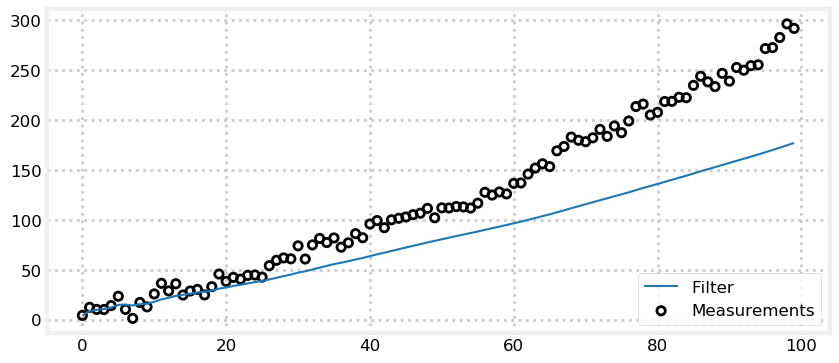

In [28]:
sensor_var = 20.
process_var = .001
process_model = gaussian(1., process_var)
pos = gaussian(0., 500.)
N = 100
dog = DogSimulation(pos.mean, 1, sensor_var, process_var*10000)
zs, ps = [], []
for _ in range(N):
    dog.velocity += 0.04
    zs.append(dog.move_and_sense())

for z in zs:
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

很容易看出，滤波器对测量值的响应不正确。测量结果清楚地表明狗在改变速度，但滤波器被告知它的预测几乎是完美的，所以它几乎完全忽略了它们。我建议你调整狗的活动量和过程差异。我们还将在后面的章节中更多地研究这个主题。关键是要认识到数学要求方差正确地描述系统。滤光片不会“注意到”它偏离了测量值并自行校正。它根据先验和测量的方差计算卡尔曼增益，并根据哪个估计更准确。

## 示例:坏的初始估计
 
现在让我们看看当我们对位置做出错误的初始估计时的结果。为了避免模糊结果，我将把传感器方差减少到30，但将初始位置设置为1000米。过滤器能从1000米的误差中恢复吗?

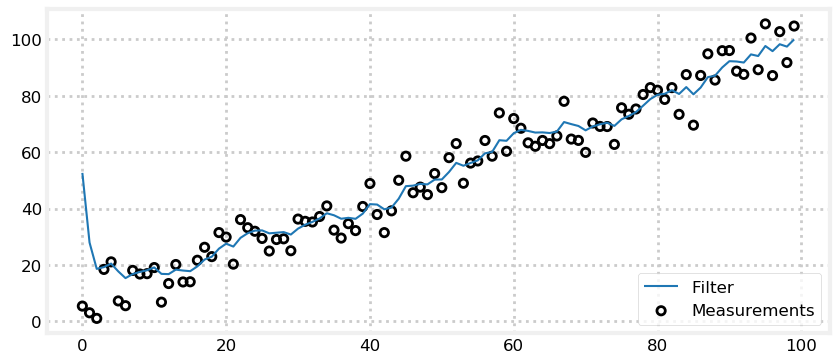

In [29]:
sensor_var = 5.**2
process_var = 2.
pos = gaussian(1000., 500.)
process_model = gaussian(1., process_var)
N = 100
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for z in zs:
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

答案同样是肯定的!因为我们相对确信我们对传感器的信任($\sigma^2=5^2$)，仅仅在第一步之后，我们就把我们的位置估计从1000米改变到大约5000米。在另外5-10次测量之后，我们已经收敛到正确的值。这就是我们如何解决最初猜测的“先有鸡还是先有蛋”的问题。在实践中我们可能会分配第一测量传感器的初始值,但你可以看到它并不重要,如果我们疯狂猜测初始条件——卡尔曼滤波器仍然是收敛的,只要选择滤波器方差匹配实际的过程和测量方差。

## 示例: 较大的噪声和较差的初始估计

那两个世界中最糟糕的情况呢，大噪音和糟糕的初始估计?

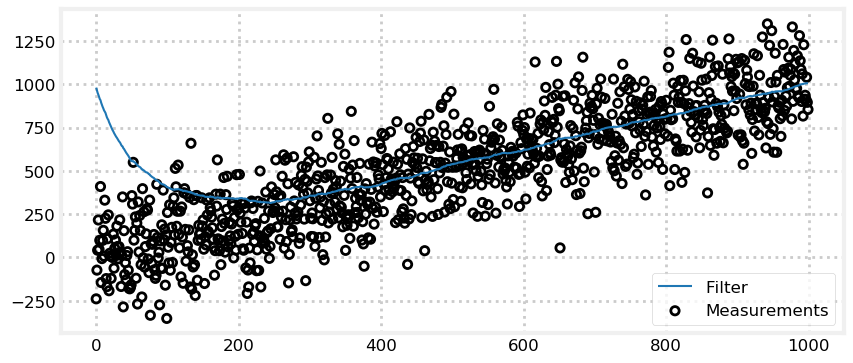

In [30]:
sensor_var = 30000.
process_var = 2.
pos = gaussian(1000., 500.)
process_model = gaussian(1., process_var)

N = 1000
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for z in zs:
    prior = predict(pos, process_model) 
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

这一次，过滤器开始挣扎了。注意，前面的示例只计算了100个更新，而本示例使用了1000个。在我看来，过滤器需要大约400次迭代才能达到合理的精确度，但可能超过600次才能得到好的结果。卡尔曼滤波器很好，但我们不能期待奇迹。如果我们有非常嘈杂的数据和非常糟糕的初始条件，这就是最好的结果了。

最后，让我们实现使用第一次测量作为初始位置的建议。

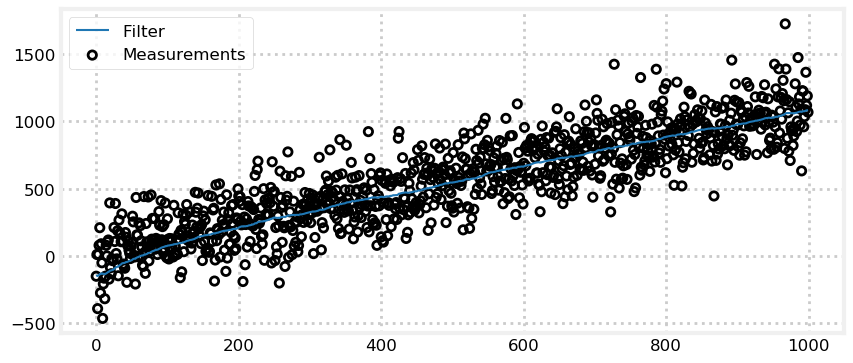

In [31]:
sensor_var = 30000.
process_var = 2.
process_model = gaussian(1., process_var)
N = 1000
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

pos = gaussian(zs[0], 500.)
ps = []
for z in zs:
    prior = predict(pos, process_model) 
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc='best');

这个简单的改变显著提高了结果。在一些运行中，需要200次左右的迭代才能得到一个好的解决方案，但在其他运行中，它会非常迅速地收敛。这完全取决于第一次测量中的噪声量。大量的噪声导致初步估计远离狗的位置。

200次迭代看似很多，但我们所注入的噪音却是巨大的。在现实世界中，我们使用的传感器有温度计、激光测距仪、GPS卫星、计算机视觉等等。在这些例子中没有一个有巨大的错误。便宜温度计的合理方差可能是0.2 C$^{\circ 2}$，而我们的代码使用了30,000 C$^{\circ 2}$。

## 练习:互动绘图
 
使用Jupyter Notebook的动画功能实现Kalman过滤器，允许您使用滑块实时修改各种常量。请参阅**高斯函数**章节中的**交互式高斯函数**来了解如何做到这一点。您将使用`interact()`函数来调用计算和绘图函数。传入`interact()`的每个参数都会自动为其创建一个滑块。我已经为此编写了样板文件;您填写所需的代码。

In [14]:
from ipywidgets import interact
from kf_book.book_plots import FloatSlider

def plot_kalman_filter(start_pos, 
                       sensor_noise, 
                       velocity, 
                       process_noise):
    plt.figure();
    # your code goes here

interact(plot_kalman_filter,
         start_pos=(-10, 10), 
         sensor_noise=FloatSlider(value=5, min=0, max=100), 
         velocity=FloatSlider(value=1, min=-2., max=2.), 
         process_noise=FloatSlider(value=5, min=0, max=100.));

interactive(children=(IntSlider(value=0, description='start_pos', max=10, min=-10), FloatSlider(value=5.0, con…

### 解决方案
 
一个可能的解决方案如下。我们用滑块表示起始位置，传感器中的噪声量，我们在每个时间步进中移动的量，以及有多少移动误差。过程噪声可能是最不清晰的——它模拟了狗在每个时间步骤中偏离路线的程度，所以我们将它添加到狗在每个步骤中的位置。我设置了随机数生成器的种子，以便每次重绘都使用相同的随机数，这样我们就可以在移动滑块时比较图表

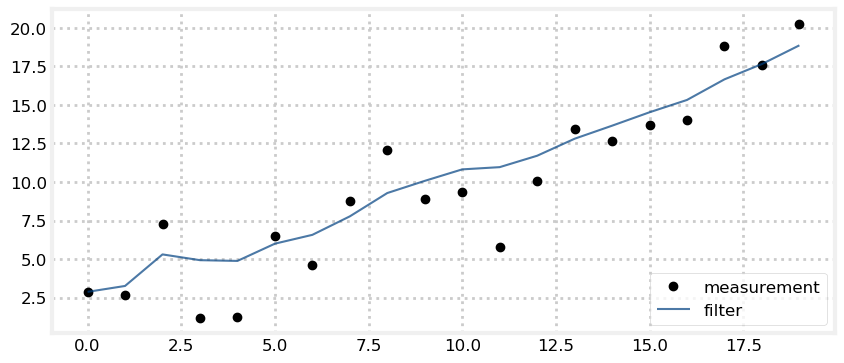

In [33]:
from numpy.random import seed 
from ipywidgets import interact

def plot_kalman_filter(start_pos, 
                       sensor_noise, 
                       velocity,
                       process_noise):
    N = 20
    zs, ps = [], []   
    seed(303)
    dog = DogSimulation(start_pos, velocity, sensor_noise, process_noise)
    zs = [dog.move_and_sense() for _ in range(N)]
    pos = gaussian(0., 1000.) # mean and variance
    process_model = gaussian(velocity, process_noise)
    
    for z in zs:    
        pos = predict(pos, process_model)
        pos = update(pos, gaussian(z, sensor_noise))
        ps.append(pos.mean)

    plt.figure()
    plt.plot(zs, c='k', marker='o', linestyle='', label='measurement')
    plt.plot(ps, c='#004080', alpha=0.7, label='filter')
    plt.legend(loc=4);

interact(plot_kalman_filter,
         start_pos=(-10, 10), 
         sensor_noise=FloatSlider(value=5, min=0., max=100), 
         velocity=FloatSlider(value=1, min=-2., max=2.), 
         process_noise=FloatSlider(value=.1, min=0, max=40));

## 示例 - 非线性系统

卡尔曼滤波器的方程是线性的:

$$\begin{aligned}
\mathcal{N}(\bar\mu,\, \bar\sigma^2) &= \mathcal{N}(\mu,\, \sigma^2) + \mathcal{N}(\mu_\mathtt{move},\, \sigma^2_\mathtt{move})\\
\mathcal{N}(\mu,\, \sigma^2) &= \mathcal{N}(\bar\mu,\, \bar\sigma^2)  \times \mathcal{N}(\mu_\mathtt{z},\, \sigma^2_\mathtt{z})
\end{aligned}$$

你认为这个过滤器在非线性系统中工作得好还是不好?

实现一个卡尔曼滤波器，使用下面的方程来生成测量值

```python
for i in range(100):
    z = math.sin(i/3.) * 2
```
调整方差和初始位置，看看效果。例如，一个非常糟糕的初始猜测的结果是什么?

In [34]:
#enter your code here.

### 解决方案

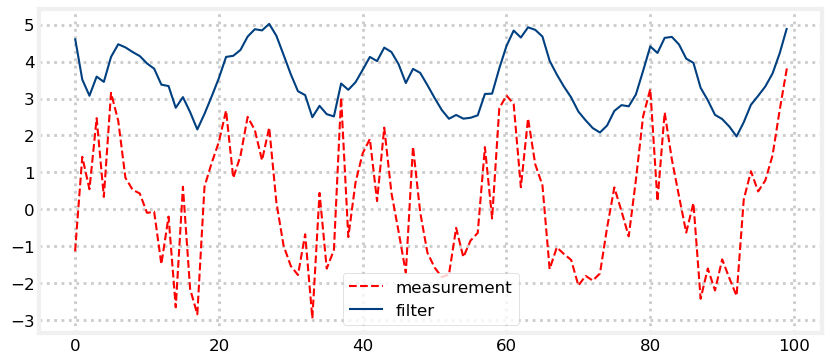

In [35]:
import math

sensor_var = 30.
process_var = 2.
pos = gaussian(100., 500.)
process_model = gaussian(1., process_var)

zs, ps = [], []

for i in range(100):
    pos = predict(pos, process_model)

    z = math.sin(i/3.)*2 + randn()*1.2
    zs.append(z)
    
    pos = update(pos, gaussian(z, sensor_var))
    ps.append(pos.mean)

plt.plot(zs, c='r', linestyle='dashed', label='measurement')
plt.plot(ps, c='#004080', label='filter')
plt.legend(loc='best');

### 讨论

This is terrible! The output is not at all like a sin wave, except in the grossest way. With linear systems we could add extreme amounts of noise to our signal and still extract a very accurate result, but here even modest noise creates a very bad result.
这是糟糕的!输出一点也不像正弦波，除了以最粗鄙的方式。在线性系统中，我们可以在信号中加入极端数量的噪声，但仍然可以提取出非常精确的结果，但在这里，即使是适度的噪声也会产生非常糟糕的结果。
  
如果我们回想一下**g-h Filter**一章，就能理解这里发生了什么。g-h滤波器的结构要求滤波器输出选择一个介于预测和测量之间的值路。像这样的变化信号总是在加速，而我们的过程模型假设速度是恒定的，所以滤波器在数学上保证总是滞后于输入信号。

在实践者开始实施卡尔曼滤波器后不久，他们就认识到在非线性系统中卡尔曼滤波器的不良性能，并开始设计处理它的方法。后面的章节将专门讨论这个问题。

## 固定增益过滤器

嵌入式计算机通常有非常有限的处理器。许多没有浮点电路。这些简单的方程式会给芯片带来沉重的负担。随着技术的进步，这种情况就不那么真实了，但不要低估在一个处理器上少花一美元的价值，因为你将购买数百万个处理器。
 
在上面的例子中，滤波器的方差收敛到一个固定值。如果测量和过程的方差是常数，那么这种情况总是会发生。您可以通过运行模拟来确定方差收敛到什么位置，从而利用这一事实。然后您可以将此值硬编码到筛选器中。只要您将过滤器初始化为一个良好的初始猜测(我建议使用第一个测量值作为初始值)，那么过滤器就会执行得非常好。例如，狗跟踪过滤器可以简化为:

```python
def update(x, z):
    K = .13232  # experimentally derived Kalman gain
    y = z - x   # residual
    x = x + K*y # posterior
    return x
    
def predict(x):
    return x + vel*dt
```
我使用更新函数的卡尔曼增益形式来强调我们根本不需要考虑方差。如果方差收敛到一个值，那么卡尔曼增益也收敛到一个值。

## FilterPy的实现
 
FilterPy实现了`predict()`和`update()`。它们不仅适用于本章中发展的单变量情况，也适用于我们在后续章节中学习的更一般的多变量情况。因此，它们的界面略有不同。它们不把高斯函数作为元组，而是作为两个单独命名的变量。

`predict()`有几个参数，但我们只需要使用这四个:

```python
predict(x, P, u, Q)
```
`x`是系统的状态。`P`是系统的方差。`u`是由于这个过程产生的运动，`Q`是这个过程中的噪音。当调用 `predict()`时，需要使用命名参数，因为大多数参数都是可选的。`predict()`的第三个参数是**而不是** `u`。
 
这些可能会让您觉得是糟糕的变量名。他们!正如我已经提到的，它们来自控制理论的长期历史，你读的每一篇论文或每一本书都会使用这些名字。所以，我们只需要习惯它。拒绝记住它们意味着你将永远无法阅读文献。
 
让我们尝试一下状态$\mathcal N(10,3)$和移动$\mathcal N(1,4)$。我们期望最终的位置是11(10+1)，方差是7(3+4)。

In [36]:
import filterpy.kalman as kf
kf.predict(x=10., P=3., u=1., Q=4.)

(11.0, 7.0)

`update`也有几个参数，但现在你会对这四个参数感兴趣:
 
```python
update(x, P, z, R)
```
如前所述，`x`和`P`是系统的状态和方差。`z`是测量值，`R`是测量方差。让我们执行最后一个预测语句来获取我们的prior，然后执行更新: 

In [15]:
x, P = kf.predict(x=10., P=3., u=1., Q=2.**2)
print('%.3f' % x)

x, P = kf.update(x=x, P=P, z=12., R=3.5**2)
print('%.3f' % x, '%.3f' % P)

NameError: name 'kf' is not defined

我给它一个有很大方差的噪声测量，所以估计仍然接近于11的先验值。
 
最后一个点。我没有使用变量名‘prior’作为预测步骤的输出。在本书的其余部分中，我将不再使用这个变量名。卡尔曼滤波方程只使用$\mathbf x$。先验和后验都是系统状态的估计，前者是纳入测量前的估计，后者是纳入测量后的估计。

## 总结
 
我们在这一章中描述的卡尔曼滤波器是我们接下来将学习的更一般滤波器的一个特殊的、有限制的情况。大多数文本并没有讨论这种一维形式。然而，我认为这是一个至关重要的垫脚石。我们从g-h滤波器开始，然后实现了离散贝叶斯滤波器，现在实现了一维卡尔曼滤波器。我已经试着向你们展示了这些过滤器使用相同的算法和推理。我们将很快学到的卡尔曼滤波器的数学是相当复杂的，它可能很难理解滤波器的潜在简单性。这种复杂性带来了显著的好处:广义过滤器将显著优于本章中的过滤器。
 
这一章需要时间来理解。要真正理解它，你可能需要反复阅读这一章。我鼓励您更改代码中的各种常量并观察结果。让自己相信高斯函数很好地代表了一条狗在走廊里的位置，一架飞机在天空中的位置，或者一个化学反应室的温度。然后说服自己，高斯函数的乘法确实可以从你先前的信念和新的测量值中计算出一个新的信念。最后，说服自己，如果你正在测量运动，那么把高斯函数加在一起就会更新你的信念。

最重要的是，花足够的时间阅读算法的完整描述部分，以确保您理解算法以及它与g-h滤波器和离散贝叶斯滤波器的关系。这里只有一个“窍门”——在预测和测量之间选择一个值。每一种算法都用不同的数学方法来实现这个技巧，但都使用相同的逻辑。